In [19]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import font_manager as fm
fm.findfont('Helvetica')

u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'

In [10]:
#import data frames from csv files. Credit to Andersen Lab at https://github.com/andersen-lab/Zika-cases-PAHO

caribbean_df = pd.read_csv('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/andersen-paho-cases/caribbean.csv')
central_america_df = pd.read_csv('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/andersen-paho-cases/central-america.csv')
south_america_df = pd.read_csv('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/andersen-paho-cases/south-america.csv')
caribbean_df

,susp/con ZIKV cases,Unnamed: 1,Unnamed: 2,Anguilla,Antigua-Barbuda,Aruba,Bahamas,Barbados,British Virgin Islands,Cayman Islands,...,St. Martin/Maarten,St. Kitts/Nevis,Trinidad/Tobago,Turks/Caicos,US Virgin Islands,Unnamed: 28,St. Thomas,St. Croix,St. John,**represented collectively as USVI
0,year,date,epi week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,3-Jan,1,0.0,0.0,10.0,0.0,16.0,0.0,2.0,...,0.0,0.0,0.0,0.0,7.0,NaN,3.0,4.0,0.0,NaN
2,NaN,10-Jan,2,0.0,0.0,10.0,0.0,32.0,0.0,2.0,...,0.0,0.0,0.0,0.0,6.0,NaN,2.0,4.0,0.0,NaN
3,NaN,17-Jan,3,0.0,0.0,20.0,0.0,53.0,0.0,0.0,...,3.0,0.0,0.0,0.0,10.0,NaN,5.0,5.0,0.0,NaN
4,NaN,24-Jan,4,3.0,0.0,18.0,0.0,80.0,0.0,3.0,...,15.0,0.0,0.0,1.0,11.0,NaN,4.0,7.0,0.0,NaN
5,NaN,31-Jan,5,0.0,0.0,22.0,0.0,86.0,0.0,2.0,...,10.0,0.0,0.0,2.0,16.0,NaN,6.0,10.0,0.0,NaN
6,NaN,7-Feb,6,0.0,0.0,27.0,0.0,51.0,0.0,1.0,...,21.0,0.0,1.0,3.0,22.0,NaN,11.0,11.0,0.0,NaN
7,NaN,14-Feb,7,0.0,0.0,32.0,0.0,45.0,0.0,2.0,...,21.0,0.0,2.0,2.0,20.0,NaN,3.0,17.0,0.0,NaN
8,NaN,21-Feb,8,0.0,0.0,36.0,0.0,22.0,0.0,4.0,...,25.0,0.0,1.0,0.0,14.0,NaN,9.0,4.0,1.0,NaN
9,NaN,28-Feb,9,1.0,0.0,34.0,0.0,17.0,0.0,3.0,...,19.0,0.0,0.0,0.0,24.0,NaN,10.0,14.0,0.0,NaN


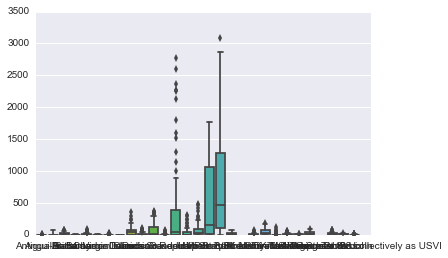

In [18]:
#plot usvi incidence
sns.boxplot(data=caribbean_df)
plt.show()

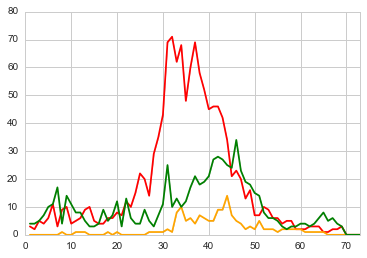

In [38]:
sns.set_style("whitegrid")
sns.tsplot(data=caribbean_df['St. Thomas'], color='red')
sns.tsplot(data=caribbean_df['St. John'], color = 'orange')
sns.tsplot(data=caribbean_df['St. Croix'], color = 'green')